In [252]:
from random import uniform, random, randint
from math import sin, pi, ceil, log
import matplotlib.pyplot as plt

First of all, we will define the function we have to maximize

In [253]:
# Define the function given in the exercise
def f(x, y):
    return 21.5 + x + sin(4*pi*x)+ y * sin(20*pi*y) 

In order to implement a genetic algorithm, we have to define a class that represents the concept of **chromosome**. It should the current point it is in (x and y) and all that is needed in order to represent those numbers in base 2 (boundaries, number of bits, precision). Later on, during the implementation of the algorithm, we realized it is convenient to include also the selection and cumulative probabilities. Also, we added a method to calculate the fitness (in this case, the value of f in the current point)

In [254]:
# Precision defined by the number of wanted decimals
class Chromosome:
    def __init__(self, x_min, x_max, y_min, y_max, decimals):
        # Straight-forward constructor logic
        self.precision = decimals
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

        # Selection probability
        self.probability = 0
        self.cumulative = 0

        # Number of needed bits
        self.bits_x = ceil(log(abs(x_max - x_min) * (10**decimals),2))
        self.bits_y = ceil(log(abs(y_max - y_min) * (10**decimals),2))

        # Initialize current x and y depending on constraints
        self.x = uniform(self.x_min, self.x_max)
        self.y = uniform(self.y_min, self.y_max)

    # Get string representation from decimal representation
    def get_binaries(self):
        bin_x = round((self.x - self.x_min) * (2**self.bits_x - 1) / abs(self.x_max - self.x_min))
        bin_y = round((self.y - self.y_min) * (2**self.bits_y - 1) / abs(self.y_max - self.y_min))
        return "{0:b}".format(bin_x), "{0:b}".format(bin_y)

    # Set decimal representation given a binary
    def set_decimals(self, bin_x, bin_y):
        self.x = abs(self.x_max - self.x_min) * int(bin_x, 2) / (2**self.bits_x - 1) + self.x_min
        self.y = abs(self.y_max - self.y_min) * int(bin_y, 2) / (2**self.bits_y - 1) + self.y_min
        return self.x, self.y
    
    # Fitness is function evaluation
    def fitness(self):
        return f(self.x, self.y)

Before implementing the main workflow of the algorithm, we should implement methods that take care of the need subroutines: mutation, over-crossing and wheeling.

In [255]:
# Function in charge of mutating given chromosomes for a given mutation rate
def mutate(population, rate):
    # For each chromosome
    for chr in population:
        # For the given rate
        if rate > random():
            # Get binaries
            bin_x, bin_y = chr.get_binaries()

            # Choose a random bit to mutate from x and y
            index_x = randint(0, len(bin_x) - 1)
            index_y = randint(0, len(bin_y) - 1)

            # Swap the position's value
            list_x = list(bin_x)
            list_x[index_x] = str(1 - int(bin_x[index_x]))
            bin_x = ''.join(list_x)

            list_y = list(bin_y)
            list_y[index_y] = str(1 - int(bin_y[index_y]))
            bin_y = ''.join(list_y)

            # Update the values in the chromosome
            chr.set_decimals(bin_x, bin_y)

In [256]:
# Function in charge of crossing two chromosomes over
def crossover(population, rate):
    # For each chromosome 
    for chr in population:
        # For the given rate
        if rate > random():
            # Choose a random chromosome to cross over with
            chr2_index = randint(0, len(population) - 1)
            chr2 = population[chr2_index]

            # Choose a random bit to split both x and y
            index_x = randint(0, chr.bits_x - 1)
            index_y = randint(0, chr.bits_y - 1)

            # Get binaries
            bin_x1, bin_y1 = chr.get_binaries()
            bin_x2, bin_y2 = chr2.get_binaries()
            
            # Perform the cross over in both chromosomes
            aux_x1 = bin_x1[:index_x] + bin_x2[index_x:] 
            aux_y1 = bin_y1[:index_y] + bin_y2[index_y:]
        
            aux_x2 = bin_x2[:index_x] + bin_x1[index_x:]
            aux_y2 = bin_y2[:index_y] + bin_y1[index_y:]
            
            # Update the values in both chromosomes
            chr.set_decimals(aux_x1, aux_y1)
            chr2.set_decimals(aux_x2, aux_y2)

In [257]:
# Roulette wheel with slots
def roulette_wheel(population):           
    # Find the total fitness
    total_fitness = 0
    for chr in population:
        total_fitness += chr.fitness()
    
    # Selection probability for each chromosome
    for chr in population:
        chr.probability = chr.fitness() / total_fitness

    # Cumulative proabability for each chromosome
    cumulative = 0
    for chr in population:
        cumulative += chr.probability
        chr.cumulative = cumulative
        
    # Selection process
    new_population = []
    for spin in range(len(population)):
        r = random()  

        # Depending on the cumulative prob of the selected chromosome
        # First chromosome is a corner case
        if r < population[0].cumulative:
            new_population.append(population[0])
        # Otherwise, general case check
        else:
            for j in range(1,len(population)):
                if population[j-1].cumulative < r <= population[j].cumulative:
                    new_population.append(population[j])
                    break
                
    return new_population

As the main workflow, we will present a method that generates a first population of random chromosomes. Then each iteration, we will mutate, cross over and wheel. We will keep the best chromosome fitness in each iteration and then return the best point at the end.

In [262]:
def genetic_algorithm(x_min, x_max, y_min, y_max, decimals, mut_rate, cross_rate, M, gens):
    # First population
    population = []
    for i in range(M):
        chr = Chromosome(x_min, x_max, y_min, y_max, decimals)
        population.append(chr)

    # Execute for the given number of generations
    best_fitness = []
    best_overall = 0 # Function always positive
    for gen in range(gens):
        # Check best fitness among all chromosomes and keep the best one
        best_val = population[0].fitness()
        for chr in population:
            if best_val < chr.fitness():
                best_val = chr.fitness()
                if best_overall < best_val:
                    best_overall = best_val
                    print("New best fitness at gen", gen, ":", best_val)
                    print("Evaluating at:", chr.x, chr.y)
        best_fitness.append(best_val)
        
        # Main Iteration
        mutate(population, mut_rate)
        crossover(population, cross_rate)
        population = roulette_wheel(population)
    
    # Plot results
    plt.figure()
    x = range(gens)
    plt.plot(x, best_fitness)
    plt.show()

We will show in a plot the best fitness for each iteration. It is observable that the best fitness is always reached in the first iterations and then the algorithm converges to a way worse point. We could consider implementing an early stopping mechanism in order to avoid running the algorithm for useless generations. The algorithm generally returns a fitness over 38 and many times over 39, when the maximum is rather closer to 40. We could also take into account the possibility of running the same algorithm several times with different fresh populations and get the best result obtained by them all, this way we would overcome the handicap of starting with a randomly 'worse' population.

New best fitness at gen 0 : 33.500857541432424
Evaluating at: 5.641834514767037 5.423024821637526
New best fitness at gen 0 : 35.978775545972155
Evaluating at: 10.28824012376856 4.919733104503717
New best fitness at gen 0 : 37.20156468721815
Evaluating at: 11.961132585410045 5.015850935863773
New best fitness at gen 1 : 39.89059931879073
Evaluating at: 12.092477350148583 5.423005554538241


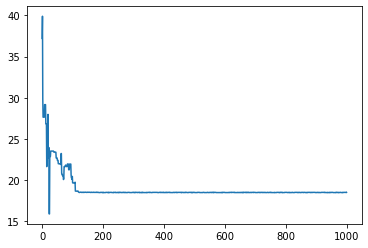

In [277]:
# Using the precision, rates and num of generations used in the example
genetic_algorithm(-3, 12.11, 4.5, 5.8, 4, 0.01, 0.25, 50, 1000)